In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

%pylab inline

warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#reading data
rubix5_eda = pd.read_csv('../Downloads/export_cab.csv')

# apply filters - prepared by Julie, Thank you, Julie!
"""
    The Rubix 5 dataset is already limited to:
-Policies effective 1-1-2015 and later
-CSL only
-Power units only (no trailers)
-For Hire Trucking only (no public auto, business auto or garage)

Onyshchenko, Igor Additional filters needed will be SCHEDULED_FLEET = "YES" and COMPANY <> "FREEDOM SPECIALTY"
I think this covers it.  Let me know if anyone thinks I missed anything.
"""

rubix5_eda = rubix5_eda[rubix5_eda['SCHEDULED_FLEET']=="YES"]
rubix5_eda = rubix5_eda[rubix5_eda['COMPANY'] != 'FREEDOM SPECIALTY']

# there still was 'Brokerage Trans' and 'Business Auto' for I'm filtering it
rubix5_eda = rubix5_eda[rubix5_eda['VEHICLE_SEGMENT'].isin(['Large Fleet','Mid Fleet','Non Fleet'])]
rubix5_eda = rubix5_eda[rubix5_eda['POLICY_SEGMENT'].isin(['Large Fleet','Mid Fleet','Non Fleet'])]

#filtering earned exposures ==0 572 cases and <0 in 13 cases
rubix5_eda = rubix5_eda[rubix5_eda['EARNED_EXPOSURES'] > 0]

#filtering POLICYSTATE != 'HI' and 'MA'
rubix5_eda = rubix5_eda[rubix5_eda['POLICYSTATE'].isin(['HI', 'MA']) == False]

# filtering CLASS_CODE != 748900 - Non-Trucking 
rubix5_eda = rubix5_eda[rubix5_eda['CLASS_CD']!=748900]


# adding a column from Julie
rubix5_eda['REGION'] = rubix5_eda['POLICYSTATE'].copy()
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'CA', 'REGION'] = 'CALIFORNIA' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'FL', 'REGION'] = 'FLORIDA' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'TX', 'REGION'] = 'TEXAS' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["CT","DE","MA","MD","ME","NH","NJ","NY","PA","RI","VA","VT","WV"]), 'REGION'] = 'EAST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["IA","IL","IN","KS","KY","MI","MN","MO","ND","NE","OH","OK","SD","WI"]), 'REGION'] = 'MIDWEST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AL","AR","GA","LA","MS","NC","SC","TN"]), 'REGION'] = 'SOUTHEAST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AZ","CO","ID","MT","NM","NV","OR","UT","WA","WY"]), 'REGION'] = 'WEST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AK","HI"]), 'REGION'] = 'OTHER' 

#resetting indexes
rubix5_eda.reset_index(drop=True, inplace = True)
# del rubix5_eda['Unnamed: 0']
rubix5_eda.head()

,DOT_NUMBER,POLICYID,POLICY_EFF_DT,VEHICLE_NO,POLICY_EXP_DT,POLICYSTATUS,POLICYISSUETYPE,COMPANY,POLICYSTATE,STATE_ADMITTED,...,DRIVER_POWER_UNIT_RATIO,HOT_ZONE_INsPECTIONS,HOT_ZONE_RATIO,PREVIOUS_INSURERS,LENGTH_WITH_PRIOR,CRASHES_SEASON_1,CRASHES_SEASON_2,CRASHES_SEASON_3,CRASHES_SEASON_4,REGION
0,831876,CAI0038074,2015-02-24,4,2016-02-24,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,TX,A,...,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,TEXAS
1,Unknown,CAI0043676,2015-07-11,1,2016-07-11,Cancelled,Renewal,SCOTTSDALE INDEMNITY COMPANY,CA,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CALIFORNIA
2,Unknown,CAI0043717,2016-06-04,3,2017-06-04,Renewed,New,SCOTTSDALE INDEMNITY COMPANY,TX,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEXAS
3,643526,CAI0044410,2018-04-29,16,2019-04-29,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,KY,A,...,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,MIDWEST
4,422450,CAI0048094,2015-10-25,30,2016-10-25,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,IL,A,...,1.5,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,MIDWEST


In [3]:
# keep only features that can be used for modelling
# the list of features prepared by Amanpreet and checked by Jason and Tyler, Thank you guys!

selected_columns = ['POLICYID',
'POLICY_EFF_DT',
'POLICYSTATUS',
'COMPANY',
'NEW_VENTURE',
'PKGCOMBO',
'YRSINBUSCT',
'YRSOFINSCT',
'POLICYSTATE',
'POLICY_SEGMENT',
'SCHEDULED_FLEET',
'VEHICLE_SEGMENT',
'VEHICLE_STATE',
'MODEL_YEAR',
'EQUIPMENT_AGE',
'VIN',
'RADIUS_GROUP',
'ZONE_GRPCD_VEHICLE',
'VEHICLE_ZIPCD',
'VEHICLE_TYPE',
'TRANSFORM_TERRITORY',
'TERRITORY_GRP',
'OPERATION_EXPOSURE_VEHICLE',
'AVG_DRIVER_SURCHARGE',
'VEHICLE_COUNT',
'LIMIT_CSL',
'DEDUCTIBLE_LIAB_TYPE',
'DEDUCTIBLE_LIAB_AMT',
'EARNED_EXPOSURES',
'CLAIM_COUNT_PAID',
# CAB features
# 'CRASH_SCORE',
# 'BASIC_ALERTS',
# 'DRIVER_INSPECTIONS',
# 'DRIVER_OUT_OF_SERVICE',
# 'DRIVER_OOS_RATIO',
# 'VEHICLE_INSPECTIONS',
# 'VEHICLE_OUT_OF_SERVICE',
# 'VEHICLE_OOS_RATIO',
# 'DRIVING_WITHOUT_CDL',
# 'DRIVING_WO_CDL_RATIO',
# 'MCS150_UNIT_COUNT',
# 'MILEAGE_POWER_UNIT_RATIO',
# 'DRIVER_POWER_UNIT_RATIO',
# 'HOT_ZONE_INsPECTIONS',
# 'HOT_ZONE_RATIO',
# 'PREVIOUS_INSURERS',
# 'LENGTH_WITH_PRIOR',
# 'CRASHES_SEASON_1',
# 'CRASHES_SEASON_2',
# 'CRASHES_SEASON_3',
# 'CRASHES_SEASON_4',
'REGION'
]


df = rubix5_eda[selected_columns]

# initial feature engineering
df['POLICY_YEAR'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[:4]).astype('int')
df['POLICY_MONTH'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[5:7]).astype('int')

df['VIN_GRP1'] = df['VIN'].apply(lambda x: str(x)[:1])
df.loc[df['VIN_GRP1'].isin(['1','2','3','4','5'])==False, 'VIN_GRP1'] = 'OTHER'

df['VIN_GRP2'] = df['VIN'].apply(lambda x: str(x)[:2])
df.loc[df['VIN_GRP2'].isin(['3W', '2X', '3F', '5P', '2N', '2W', '3C', '5K', '2F', '1G', '3H',
                           '1N','1H','1M', '2H', '3A', '4V', '1F', '1X'])==False, 'VIN_GRP2'] = 'OTHER'

df['VIN_GRP3'] = df['VIN'].apply(lambda x: str(x)[:3])
df.loc[df['VIN_GRP3'].isin(['2HT','2XK','3HA','4V1','4V5','2FW','3FR','3WK', '3C7', '2NP', '2NK', '1GB', '1GC', '3C6', '4VG', '1GD', '5PV',
       '2WK', '2FZ', '2FU', '5KK', '5KJ', '1FT', '3AL', '1HS', '1FD', '1NK',
       '1M1', '1FV', '1M2', '1NP', '3HS', '1HT', '2HS', '3AK', '4V4', '1XK',
       '1XP', '1FU'])==False, 'VIN_GRP3'] = 'OTHER'

del df['VIN']
del df['POLICY_EFF_DT']

# MODEL AGE
df['MODEL_AGE'] = df['POLICY_YEAR'] - df['MODEL_YEAR'] + 1

# target definition
df['TARGET'] = df['CLAIM_COUNT_PAID'] / df['EARNED_EXPOSURES']
df['TARGET_BINARY'] = df['CLAIM_COUNT_PAID'].apply(lambda x: 1 if x>0 else 0)

df = df[df['POLICY_YEAR']<2022]

# table for Excel

In [177]:
# features for clastering
# POLICYSTATE, PKGCOMBO, YRSINBUSCT, VEHICLE_COUNT
#features = ['POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT']
features = ['POLICYID','REGION', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT']

y=2020
# reg = 'CALIFORNIA'
reg = 'EAST'

# df on policy level
tmp = df[df['POLICY_YEAR']==y].groupby('POLICYID').agg({'POLICYID': np.max,'REGION': np.max, 'POLICYSTATE': np.max, 'PKGCOMBO': np.max, 'YRSINBUSCT': np.max, 'VEHICLE_COUNT': np.max, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})

tmp.columns = ['POLICYID','REGION', 'POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT', 'CLAIM_COUNT_PAID', 'EARNED_EXPOSURES']

tmp = tmp.reset_index(drop=True)
tmp['VEHICLE_COUNT_GRP'] = pd.cut(tmp['VEHICLE_COUNT'], [1, 2, 4, 10, 25, 200], include_lowest = True, right = False)

# tmp

t = tmp[tmp['REGION']==reg].groupby('VEHICLE_COUNT_GRP').agg({'YRSINBUSCT': [np.mean, np.median], 'POLICYID': np.size, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})
t['TARGET'] = t['CLAIM_COUNT_PAID'] / t['EARNED_EXPOSURES']
t.columns = ['YRSINBUSCT_MEAN', 'YRSINBUSCT_MEDIAN', 'TOTAL_POLICIES', 'CLAIM_COUNT_PAID','EARNED_EXPOSURES', 'TARGET']

t.fillna(0, inplace = True)
t
    

,YRSINBUSCT_MEAN,YRSINBUSCT_MEDIAN,TOTAL_POLICIES,CLAIM_COUNT_PAID,EARNED_EXPOSURES,TARGET
VEHICLE_COUNT_GRP,,,,,,
"[1, 2)",10.251685,8.0,445,23,420.391781,0.054711
"[2, 4)",11.383099,7.0,355,50,659.550685,0.075809
"[4, 10)",12.342520,10.0,254,80,1189.249315,0.067269
"[10, 25)",16.424242,12.0,99,96,1117.793071,0.085884
"[25, 200)",20.850000,19.0,20,44,554.109589,0.079407


# Continue in Python

In [155]:
# features for clastering
# POLICYSTATE, PKGCOMBO, YRSINBUSCT, VEHICLE_COUNT
#features = ['POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT']
# features = ['POLICYID','REGION', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT']
features = ['POLICYID','YRSINBUSCT', 'VEHICLE_COUNT']
# features = ['POLICYID','YRSINBUSCT_GRP', 'VEHICLE_COUNT_GRP']

# df on policy level
tmp = df[(df['POLICY_YEAR']==2017) & (df['REGION']=='TEXAS')].groupby('POLICYID').agg({'POLICYID': np.max,'REGION': np.max, 'POLICYSTATE': np.max, 'PKGCOMBO': np.max, 'YRSINBUSCT': np.max, 'VEHICLE_COUNT': np.max, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})

tmp.columns = ['POLICYID','REGION', 'POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT', 'CLAIM_COUNT_PAID', 'EARNED_EXPOSURES']

tmp = tmp.reset_index(drop=True)
tmp['VEHICLE_COUNT_GRP'] = pd.cut(tmp['VEHICLE_COUNT'], [1, 2, 4, 10, 25, 200], include_lowest = True, right = False)

tmp['YRSINBUSCT_GRP'] = pd.qcut(tmp['YRSINBUSCT'], 8)

tmp

,POLICYID,REGION,POLICYSTATE,PKGCOMBO,YRSINBUSCT,VEHICLE_COUNT,CLAIM_COUNT_PAID,EARNED_EXPOSURES,VEHICLE_COUNT_GRP,YRSINBUSCT_GRP
0,CAI0043719,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,10.0,4.0,0,1.054795,"[4, 10)","(9.0, 13.0]"
1,CAI0043720,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,12.0,11.0,0,5.893151,"[10, 25)","(9.0, 13.0]"
2,CAI0043722,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,7.0,5.0,0,3.000000,"[4, 10)","(6.0, 7.0]"
3,CAI0056829,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,7.0,2.0,0,2.000000,"[2, 4)","(6.0, 7.0]"
4,CAI0063198,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,26.0,4.0,1,3.605479,"[4, 10)","(13.0, 50.0]"
5,CAO7762759,TEXAS,TX,AUTO LIABILITY ONLY,6.0,1.0,0,1.000000,"[1, 2)","(5.0, 6.0]"
6,CAO7762762,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,5.0,1.0,0,1.000000,"[1, 2)","(4.0, 5.0]"
7,CAO7762764,TEXAS,TX,AUTO LIABILITY ONLY,6.0,2.0,0,2.000000,"[2, 4)","(5.0, 6.0]"
8,CAO7762766,TEXAS,TX,AUTO LIABILITY ONLY,4.0,2.0,0,2.000000,"[2, 4)","(3.0, 4.0]"
9,CAO7762768,TEXAS,TX,AUTO LIABILITY ONLY,8.0,4.0,0,4.000000,"[4, 10)","(7.0, 9.0]"


# Manual clustering

2017 policy year
pick Arizona or top state
 create 4 clusters
    
large Fleet - size of fleet


check this through years...
see if pols of Age change 

Calif is newer than NY?


In [156]:

tt = pd.DataFrame()
for reg in set(tmp['REGION']):
    t = tmp[tmp['REGION']==reg].groupby('VEHICLE_COUNT_GRP').agg({'YRSINBUSCT': [np.mean, np.median], 'POLICYID': np.size, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})
    t['TARGET'] = t['CLAIM_COUNT_PAID'] / t['EARNED_EXPOSURES']
    t.columns = ['YRSINBUSCT_MEAN', 'YRSINBUSCT_MEDIAN', 'TOTAL_POLICIES', 'CLAIM_COUNT_PAID','EARNED_EXPOSURES', 'TARGET']
#     print(t)
    t.fillna(0, inplace = True)
    t['REGION'] = reg
    t['x'] = t.index.astype('str')
    tt = tt.append(t)

tt

,YRSINBUSCT_MEAN,YRSINBUSCT_MEDIAN,TOTAL_POLICIES,CLAIM_COUNT_PAID,EARNED_EXPOSURES,TARGET,REGION,x
VEHICLE_COUNT_GRP,,,,,,,,
"[1, 2)",7.272206,6.0,349.0,30,332.037593,0.090351,TEXAS,"[1, 2)"
"[2, 4)",7.610236,6.0,254.0,58,440.617094,0.131634,TEXAS,"[2, 4)"
"[4, 10)",7.777778,6.0,153.0,67,602.036558,0.111289,TEXAS,"[4, 10)"
"[10, 25)",7.133333,5.5,30.0,35,253.290411,0.138181,TEXAS,"[10, 25)"
"[25, 200)",0.000000,0.0,0.0,0,0.000000,0.000000,TEXAS,"[25, 200)"


TEXAS


Text(0.5,1,'Years in Business over # Vehicles - 2017')

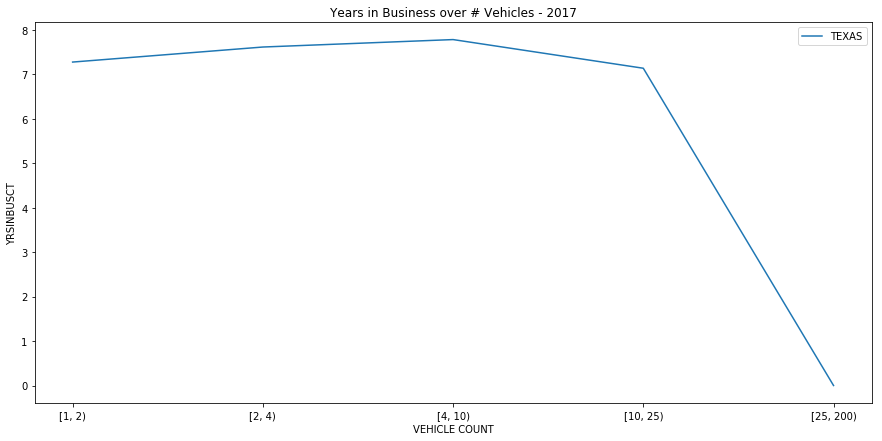

In [157]:
plt.figure(figsize = (15,7))
for r in set(tt['REGION']):
    print(r)
    plt.plot(tt[tt['REGION']==r]['x'],tt[tt['REGION']==r]['YRSINBUSCT_MEAN'], label = r)

plt.legend()
plt.xlabel('VEHICLE COUNT')
plt.ylabel('YRSINBUSCT')
plt.title('Years in Business over # Vehicles - 2017')

# summary chart
in Florida - the youngest companies ~2-5 years younger than other regions

for Texas and Florida there is no dependency of Vehicle Count vs Company Age

The most experienced companies are located on EAST region

Trend for the most populated segment - California is stable - the more Vehicles the older Company. Overall age for the companies is in the middle of our portfolio.

Text(0.5,1,'Total Policies over # Vehicles - 2017')

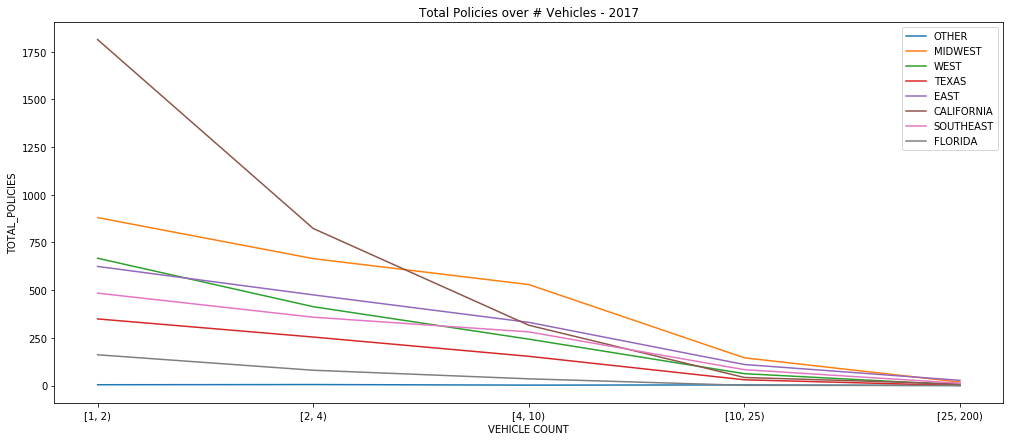

In [201]:
plt.figure(figsize = (17,7))
for r in set(tt['REGION']):
    plt.plot(tt[tt['REGION']==r]['x'],tt[tt['REGION']==r]['TOTAL_POLICIES'], label = r)

plt.legend()
plt.xlabel('VEHICLE COUNT')
plt.ylabel('TOTAL_POLICIES')
plt.title('Total Policies over # Vehicles - 2017')



# DBSCAN

In [6]:
from sklearn.cluster import KMeans, DBSCAN

In [158]:
# categories to dummy
tmp[features].isnull().sum()


POLICYID         0
YRSINBUSCT       0
VEHICLE_COUNT    0
dtype: int64

In [208]:
# tmp[features] = tmp[features].fillna(-1)
cluster_df = tmp[features]

# creating dummy variables for categorical features
# cluster_df = pd.get_dummies(cluster_df, columns = ['REGION', 'PKGCOMBO'])
# cluster_df = pd.get_dummies(cluster_df, columns = ['YRSINBUSCT_GRP', 'VEHICLE_COUNT_GRP'])

cluster_df = cluster_df.reset_index(drop = True)
cluster_df


,POLICYID,YRSINBUSCT,VEHICLE_COUNT
0,CAI0043719,10.0,4.0
1,CAI0043720,12.0,11.0
2,CAI0043722,7.0,5.0
3,CAI0056829,7.0,2.0
4,CAI0063198,26.0,4.0
5,CAO7762759,6.0,1.0
6,CAO7762762,5.0,1.0
7,CAO7762764,6.0,2.0
8,CAO7762766,4.0,2.0
9,CAO7762768,8.0,4.0


In [201]:
# normalazing VEHICLE_COUNT and YRSINBUSCT
from sklearn.preprocessing import normalize

cluster_df[['YRSINBUSCT','VEHICLE_COUNT']] = normalize(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']], norm='max')

cluster_df

,POLICYID,YRSINBUSCT,VEHICLE_COUNT
0,CAI0043719,1.000000,0.400000
1,CAI0043720,1.000000,0.916667
2,CAI0043722,1.000000,0.714286
3,CAI0056829,1.000000,0.285714
4,CAI0063198,1.000000,0.153846
5,CAO7762759,1.000000,0.166667
6,CAO7762762,1.000000,0.200000
7,CAO7762764,1.000000,0.333333
8,CAO7762766,1.000000,0.500000
9,CAO7762768,1.000000,0.500000


In [210]:
del cluster_df['POLICYID']

# Compute DBSCAN euclidian distance

In [224]:

db = DBSCAN(eps=2.5, min_samples=50).fit(cluster_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

tmp['CLUSTER_ID'] = labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 1
Estimated number of noise points: 77


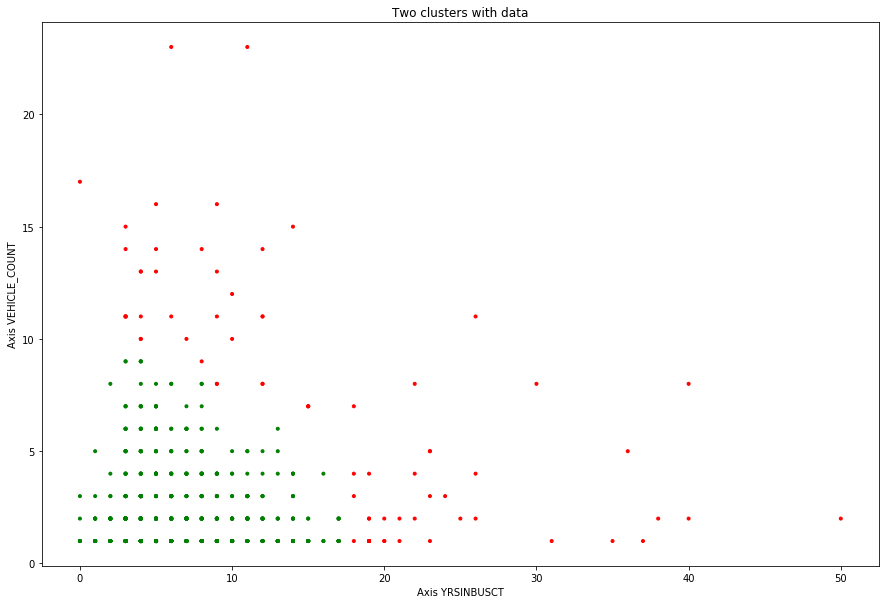

In [225]:

# Generate scatter plot for training data
colors = list(map(lambda x: 'red' if x == -1 else 'green' if x==0 else 'yellow' if x==1 else 'black' if x==2 else 'pink' if x==3 else 'blue', labels))
plt.figure(figsize = (15,10))
plt.scatter(tmp['YRSINBUSCT'], tmp['VEHICLE_COUNT'], c=colors, marker=".", picker=True)
plt.title('Two clusters with data')
plt.xlabel('Axis YRSINBUSCT')
plt.ylabel('Axis VEHICLE_COUNT')

plt.show()

1. corr Newer vs Older

2. Bigger vs Smaller

3. Size vs Age

4. business insights - bigger business is older ?


In [226]:
t = tmp.groupby('CLUSTER_ID').agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'POLICYID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
t['CLAIMS_RATE'] = t['CLAIM_COUNT_PAID']/t['POLICYID']
t['CLAIMS_EXPOSURES'] = t['CLAIM_COUNT_PAID']/t['EARNED_EXPOSURES']
t

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,POLICYID,VEHICLE_COUNT,YRSINBUSCT,CLAIMS_RATE,CLAIMS_EXPOSURES
CLUSTER_ID,,,,,,,
-1,57,388.078546,77,7.311688,16.480519,0.740260,0.146877
0,133,1239.903110,709,2.266573,6.496474,0.187588,0.107266


# DBSCAN COSINE SIMILARITY CLASTERING

Estimated number of clusters: 1
Estimated number of noise points: 162


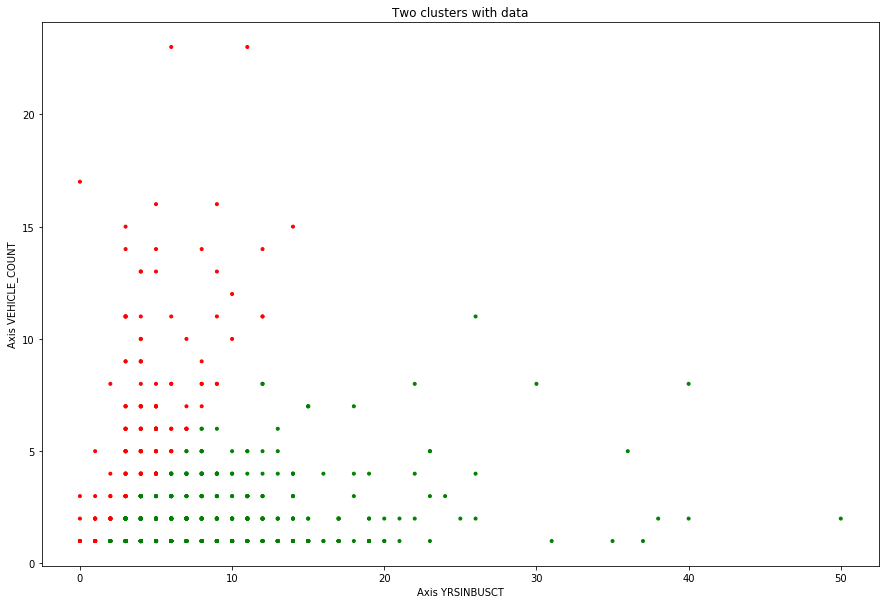

In [230]:
# Compute DBSCAN cosine similarity

db = DBSCAN(eps=0.005, min_samples=100, metric = 'cosine').fit(cluster_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

tmp['CLUSTER_ID_2'] = labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


# Generate scatter plot for training data
colors = list(map(lambda x: 'red' if x == -1 else 'green' if x==0 else 'yellow' if x==1 else 'black' if x==2 else 'pink' if x==3 else 'blue', labels))
plt.figure(figsize = (15,10))
plt.scatter(tmp['YRSINBUSCT'], tmp['VEHICLE_COUNT'], c=colors, marker=".", picker=True)
plt.title('Two clusters with data')
plt.xlabel('Axis YRSINBUSCT')
plt.ylabel('Axis VEHICLE_COUNT')

plt.show()

In [231]:
t = tmp.groupby('CLUSTER_ID_2').agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'POLICYID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
t['CLAIMS_RATE'] = t['CLAIM_COUNT_PAID']/t['POLICYID']
t['CLAIMS_EXPOSURES'] = t['CLAIM_COUNT_PAID']/t['EARNED_EXPOSURES']
t

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,POLICYID,VEHICLE_COUNT,YRSINBUSCT,CLAIMS_RATE,CLAIMS_EXPOSURES
CLUSTER_ID_2,,,,,,,
-1,93,681.449827,162,6.216049,4.160494,0.574074,0.136474
0,97,946.531829,624,1.863782,8.334936,0.155449,0.102479


# Combination of two clustering

In [233]:
t = tmp.groupby(['CLUSTER_ID','CLUSTER_ID_2']).agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'POLICYID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
t['CLAIMS_RATE'] = t['CLAIM_COUNT_PAID']/t['POLICYID']
t['CLAIMS_EXPOSURES'] = t['CLAIM_COUNT_PAID']/t['EARNED_EXPOSURES']
t

CLAIM_COUNT_PAID  EARNED_EXPOSURES  POLICYID  \
CLUSTER_ID CLUSTER_ID_2                                                 
-1         -1                          38        261.347945        32   
            0                          19        126.730601        45   
 0         -1                          55        420.101882       130   
            0                          78        819.801228       579   

                         VEHICLE_COUNT  YRSINBUSCT  CLAIMS_RATE  \
CLUSTER_ID CLUSTER_ID_2                                           
-1         -1                12.781250    6.687500     1.187500   
            0                 3.422222   23.444444     0.422222   
 0         -1                 4.600000    3.538462     0.423077   
            0                 1.742660    7.160622     0.134715   

                         CLAIMS_EXPOSURES  
CLUSTER_ID CLUSTER_ID_2                    
-1         -1                    0.145400  
            0                    0.149924  
 0         -1                    0.130921  
            0                    0.095145

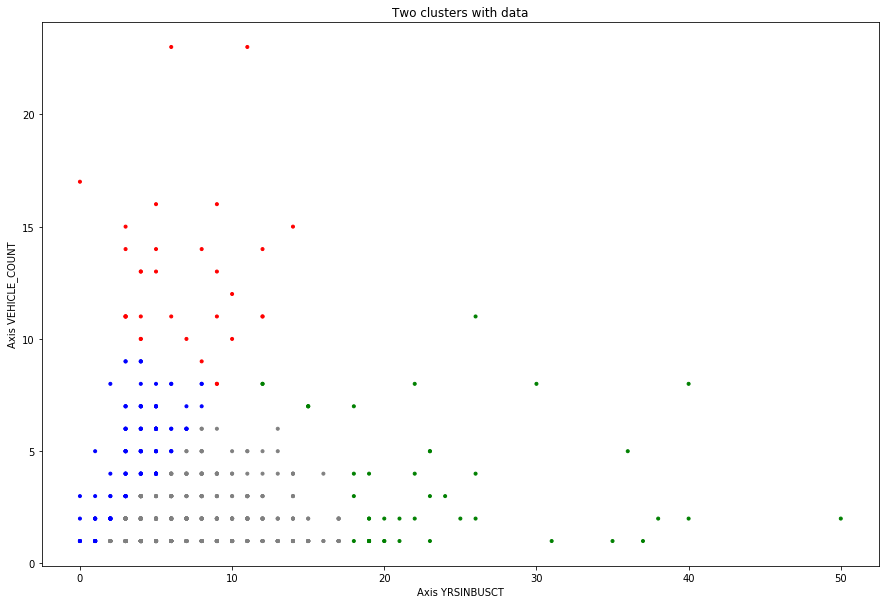

In [281]:
# Generate scatter plot for training data
tmp['CLUSTERS'] = -1
tmp.loc[(tmp['CLUSTER_ID']==-1) & (tmp['CLUSTER_ID_2']==0), 'CLUSTERS'] = 0
tmp.loc[(tmp['CLUSTER_ID']==0) & (tmp['CLUSTER_ID_2']==-1), 'CLUSTERS'] = 1
tmp.loc[(tmp['CLUSTER_ID']==0) & (tmp['CLUSTER_ID_2']==0), 'CLUSTERS'] = 2


colors = list(map(lambda x: 'red' if x == -1 else 'green' if x==0 else 'blue' if x==1 else 'grey' if x==2 else 'pink' if x==3 else 'blue', tmp['CLUSTERS']))
plt.figure(figsize = (15,10))
plt.scatter(tmp['YRSINBUSCT'], tmp['VEHICLE_COUNT'], c=colors, marker=".", picker=True)
plt.title('Two clusters with data')
plt.xlabel('Axis YRSINBUSCT')
plt.ylabel('Axis VEHICLE_COUNT')

plt.show()

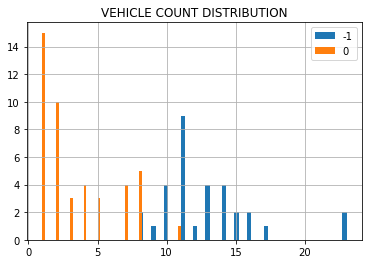

Text(0.5,1,'VEHICLE COUNT DISTICUTION')

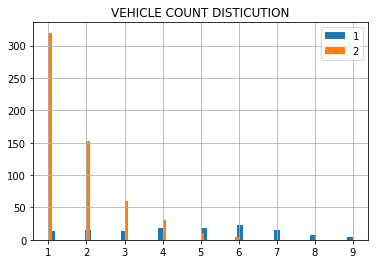

In [251]:
# tmp['VEHICLE_COUNT'].hist(bins=50)

tmp[tmp['CLUSTERS']==-1]['VEHICLE_COUNT'].hist(bins=50, label = '-1')
tmp[tmp['CLUSTERS']==0]['VEHICLE_COUNT'].hist(bins=50, label = '0')
plt.legend()
plt.title('VEHICLE COUNT DISTRIBUTION')
plt.show()
tmp[tmp['CLUSTERS']==1]['VEHICLE_COUNT'].hist(bins=50, label = '1')
tmp[tmp['CLUSTERS']==2]['VEHICLE_COUNT'].hist(bins=50, label = '2')
plt.legend()
plt.title('VEHICLE COUNT DISTICUTION')

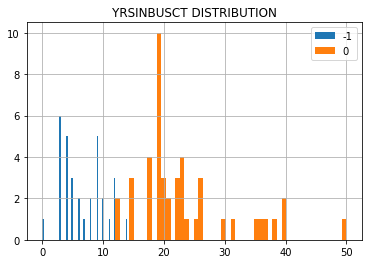

Text(0.5,1,'YRSINBUSCT DISTICUTION')

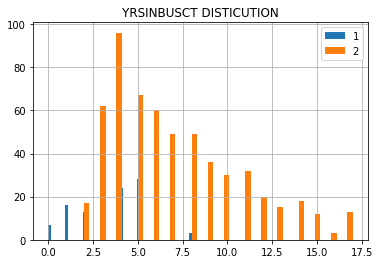

In [252]:
# tmp['VEHICLE_COUNT'].hist(bins=50)

tmp[tmp['CLUSTERS']==-1]['YRSINBUSCT'].hist(bins=50, label = '-1')
tmp[tmp['CLUSTERS']==0]['YRSINBUSCT'].hist(bins=50, label = '0')
plt.legend()
plt.title('YRSINBUSCT DISTRIBUTION')
plt.show()
tmp[tmp['CLUSTERS']==1]['YRSINBUSCT'].hist(bins=50, label = '1')
tmp[tmp['CLUSTERS']==2]['YRSINBUSCT'].hist(bins=50, label = '2')
plt.legend()
plt.title('YRSINBUSCT DISTICUTION')

In [253]:
t = tmp.groupby('CLUSTERS').agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'POLICYID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
t['CLAIMS_RATE'] = t['CLAIM_COUNT_PAID']/t['POLICYID']
t['CLAIMS_EXPOSURES'] = t['CLAIM_COUNT_PAID']/t['EARNED_EXPOSURES']
t

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,POLICYID,VEHICLE_COUNT,YRSINBUSCT,CLAIMS_RATE,CLAIMS_EXPOSURES
CLUSTERS,,,,,,,
-1,38,261.347945,32,12.781250,6.687500,1.187500,0.145400
0,19,126.730601,45,3.422222,23.444444,0.422222,0.149924
1,55,420.101882,130,4.600000,3.538462,0.423077,0.130921
2,78,819.801228,579,1.742660,7.160622,0.134715,0.095145


In [257]:
df

,POLICYID,POLICYSTATUS,COMPANY,NEW_VENTURE,PKGCOMBO,YRSINBUSCT,YRSOFINSCT,POLICYSTATE,POLICY_SEGMENT,SCHEDULED_FLEET,...,CLAIM_COUNT_PAID,REGION,POLICY_YEAR,POLICY_MONTH,VIN_GRP1,VIN_GRP2,VIN_GRP3,MODEL_AGE,TARGET,TARGET_BINARY
0,CAI0038074,Renewed,SCOTTSDALE INDEMNITY COMPANY,3RD YR NEW VENTURE,AUTO LIABILITY & AUTO PD ONLY,19.0,3.0,TX,Non Fleet,YES,...,0,TEXAS,2015,2,1,1M,1M2,9.0,0.0,0
1,CAI0043676,Cancelled,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY ONLY,5.0,NaN,CA,Non Fleet,YES,...,0,CALIFORNIA,2015,7,2,2X,2XK,31.0,0.0,0
2,CAI0043717,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY & AUTO PD ONLY,16.0,11.0,TX,Non Fleet,YES,...,0,TEXAS,2016,6,1,1M,1M2,12.0,0.0,0
3,CAI0044410,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY & AUTO PD ONLY,48.0,NaN,KY,Mid Fleet,YES,...,0,MIDWEST,2018,4,2,2N,2NK,9.0,0.0,0
4,CAI0048094,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY ONLY,16.0,NaN,IL,Mid Fleet,YES,...,0,MIDWEST,2015,10,4,4V,4V4,20.0,0.0,0
5,CAI0048097,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY ONLY,19.0,NaN,IL,Mid Fleet,YES,...,0,MIDWEST,2016,10,1,1F,1FU,15.0,0.0,0
6,CAI0056957,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY & AUTO PD ONLY,8.0,NaN,IL,Non Fleet,YES,...,0,MIDWEST,2017,11,4,4V,4V4,16.0,0.0,0
7,CAI0057005,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY ONLY,16.0,NaN,PA,Non Fleet,YES,...,0,EAST,2018,7,1,1F,1FU,14.0,0.0,0
8,CAI0060872,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY ONLY,NaN,NaN,CA,Non Fleet,YES,...,0,CALIFORNIA,2015,1,1,1F,1FU,5.0,0.0,0
9,CAI0061960,Cancelled,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY & AUTO PD ONLY,13.0,5.0,FL,Mid Fleet,YES,...,0,FLORIDA,2015,10,1,1F,1FU,12.0,0.0,0


In [258]:
tmp.groupby(['CLUSTERS','PKGCOMBO'])

,POLICYID,REGION,POLICYSTATE,PKGCOMBO,YRSINBUSCT,VEHICLE_COUNT,CLAIM_COUNT_PAID,EARNED_EXPOSURES,VEHICLE_COUNT_GRP,YRSINBUSCT_GRP,CLUSTER_ID,CLUSTER_ID_2,CLUSTERS
0,CAI0043719,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,10.0,4.0,0,1.054795,"[4, 10)","(9.0, 13.0]",0,0,2
1,CAI0043720,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,12.0,11.0,0,5.893151,"[10, 25)","(9.0, 13.0]",-1,-1,-1
2,CAI0043722,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,7.0,5.0,0,3.000000,"[4, 10)","(6.0, 7.0]",0,0,2
3,CAI0056829,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,7.0,2.0,0,2.000000,"[2, 4)","(6.0, 7.0]",0,0,2
4,CAI0063198,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,26.0,4.0,1,3.605479,"[4, 10)","(13.0, 50.0]",-1,0,0
5,CAO7762759,TEXAS,TX,AUTO LIABILITY ONLY,6.0,1.0,0,1.000000,"[1, 2)","(5.0, 6.0]",0,0,2
6,CAO7762762,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,5.0,1.0,0,1.000000,"[1, 2)","(4.0, 5.0]",0,0,2
7,CAO7762764,TEXAS,TX,AUTO LIABILITY ONLY,6.0,2.0,0,2.000000,"[2, 4)","(5.0, 6.0]",0,0,2
8,CAO7762766,TEXAS,TX,AUTO LIABILITY ONLY,4.0,2.0,0,2.000000,"[2, 4)","(3.0, 4.0]",0,0,2
9,CAO7762768,TEXAS,TX,AUTO LIABILITY ONLY,8.0,4.0,0,4.000000,"[4, 10)","(7.0, 9.0]",0,0,2


In [261]:
tmp.groupby(['CLUSTERS','PKGCOMBO']).size()

CLUSTERS  PKGCOMBO                       
-1        AUTO LIAB & MOTOR TRUCK CARGO        2
          AUTO LIAB/PD & MOTOR TRK CARGO      17
          AUTO LIAB/PD,GL & MTR TRK CARGO      7
          AUTO LIABILITY & AUTO PD ONLY        5
          AUTO LIABILITY ONLY                  1
 0        AUTO LIAB & MOTOR TRUCK CARGO        1
          AUTO LIAB/PD & MOTOR TRK CARGO      22
          AUTO LIAB/PD,GL & MTR TRK CARGO      5
          AUTO LIABILITY & AUTO PD ONLY       12
          AUTO LIABILITY ONLY                  5
 1        AUTO LIAB & MOTOR TRUCK CARGO       11
          AUTO LIAB, AUTO PD & GEN LIAB        1
          AUTO LIAB/PD & MOTOR TRK CARGO      92
          AUTO LIAB/PD,GL & MTR TRK CARGO     12
          AUTO LIABILITY & AUTO PD ONLY        7
          AUTO LIABILITY & GENERAL LIAB        2
          AUTO LIABILITY ONLY                  5
 2        AUTO LIAB & MOTOR TRUCK CARGO       29
          AUTO LIAB, AUTO PD & GEN LIAB        2
          AUTO LIAB,GL & MO

In [ ]:
# df on policy level
tmp = df[(df['POLICY_YEAR']==2017) & (df['REGION']=='TEXAS')].groupby('POLICYID').agg({'POLICYID': np.max,'REGION': np.max, 'POLICYSTATE': np.max, 'PKGCOMBO': np.max, 'YRSINBUSCT': np.max, 'VEHICLE_COUNT': np.max, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})

tmp.columns = ['POLICYID','REGION', 'POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT', 'CLAIM_COUNT_PAID', 'EARNED_EXPOSURES']

tmp = tmp.reset_index(drop=True)
tmp['VEHICLE_COUNT_GRP'] = pd.cut(tmp['VEHICLE_COUNT'], [1, 2, 4, 10, 25, 200], include_lowest = True, right = False)

tmp['YRSINBUSCT_GRP'] = pd.qcut(tmp['YRSINBUSCT'], 8)

tmp


In [262]:
df.head()

,POLICYID,POLICYSTATUS,COMPANY,NEW_VENTURE,PKGCOMBO,YRSINBUSCT,YRSOFINSCT,POLICYSTATE,POLICY_SEGMENT,SCHEDULED_FLEET,...,CLAIM_COUNT_PAID,REGION,POLICY_YEAR,POLICY_MONTH,VIN_GRP1,VIN_GRP2,VIN_GRP3,MODEL_AGE,TARGET,TARGET_BINARY
0,CAI0038074,Renewed,SCOTTSDALE INDEMNITY COMPANY,3RD YR NEW VENTURE,AUTO LIABILITY & AUTO PD ONLY,19.0,3.0,TX,Non Fleet,YES,...,0,TEXAS,2015,2,1,1M,1M2,9.0,0.0,0
1,CAI0043676,Cancelled,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY ONLY,5.0,NaN,CA,Non Fleet,YES,...,0,CALIFORNIA,2015,7,2,2X,2XK,31.0,0.0,0
2,CAI0043717,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY & AUTO PD ONLY,16.0,11.0,TX,Non Fleet,YES,...,0,TEXAS,2016,6,1,1M,1M2,12.0,0.0,0
3,CAI0044410,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY & AUTO PD ONLY,48.0,NaN,KY,Mid Fleet,YES,...,0,MIDWEST,2018,4,2,2N,2NK,9.0,0.0,0
4,CAI0048094,Renewed,SCOTTSDALE INDEMNITY COMPANY,OTHER,AUTO LIABILITY ONLY,16.0,NaN,IL,Mid Fleet,YES,...,0,MIDWEST,2015,10,4,4V,4V4,20.0,0.0,0


In [273]:
d = df[(df['POLICY_YEAR']==2017) & (df['REGION']=='TEXAS')].groupby('POLICYID').agg({'POLICYID': np.max,'COMPANY': np.max, 'NEW_VENTURE': np.max, 'POLICYSTATUS': np.max, 'POLICY_SEGMENT': np.max})
d.columns = ['POLICYID','COMPANY','NEW_VENTURE','POLICYSTATUS','POLICY_SEGMENT']
d = d.merge(tmp, on='POLICYID')
d

,POLICYID,COMPANY,NEW_VENTURE,POLICYSTATUS,POLICY_SEGMENT,REGION,POLICYSTATE,PKGCOMBO,YRSINBUSCT,VEHICLE_COUNT,CLAIM_COUNT_PAID,EARNED_EXPOSURES,VEHICLE_COUNT_GRP,YRSINBUSCT_GRP,CLUSTER_ID,CLUSTER_ID_2,CLUSTERS
0,CAI0043719,SCOTTSDALE INDEMNITY COMPANY,OTHER,Renewed,Non Fleet,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,10.0,4.0,0,1.054795,"[4, 10)","(9.0, 13.0]",0,0,2
1,CAI0043720,SCOTTSDALE INDEMNITY COMPANY,OTHER,Did Not Renew,Non Fleet,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,12.0,11.0,0,5.893151,"[10, 25)","(9.0, 13.0]",-1,-1,-1
2,CAI0043722,SCOTTSDALE INDEMNITY COMPANY,OTHER,Did Not Renew,Non Fleet,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,7.0,5.0,0,3.000000,"[4, 10)","(6.0, 7.0]",0,0,2
3,CAI0056829,SCOTTSDALE INDEMNITY COMPANY,OTHER,Renewed,Non Fleet,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,7.0,2.0,0,2.000000,"[2, 4)","(6.0, 7.0]",0,0,2
4,CAI0063198,SCOTTSDALE INDEMNITY COMPANY,OTHER,Did Not Renew,Non Fleet,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,26.0,4.0,1,3.605479,"[4, 10)","(13.0, 50.0]",-1,0,0
5,CAO7762759,NATIONAL CASUALTY COMPANY,OTHER,Did Not Renew,Non Fleet,TEXAS,TX,AUTO LIABILITY ONLY,6.0,1.0,0,1.000000,"[1, 2)","(5.0, 6.0]",0,0,2
6,CAO7762762,NATIONAL CASUALTY COMPANY,OTHER,Renewed,Non Fleet,TEXAS,TX,AUTO LIABILITY & AUTO PD ONLY,5.0,1.0,0,1.000000,"[1, 2)","(4.0, 5.0]",0,0,2
7,CAO7762764,NATIONAL CASUALTY COMPANY,OTHER,Did Not Renew,Non Fleet,TEXAS,TX,AUTO LIABILITY ONLY,6.0,2.0,0,2.000000,"[2, 4)","(5.0, 6.0]",0,0,2
8,CAO7762766,NATIONAL CASUALTY COMPANY,OTHER,Did Not Renew,Non Fleet,TEXAS,TX,AUTO LIABILITY ONLY,4.0,2.0,0,2.000000,"[2, 4)","(3.0, 4.0]",0,0,2
9,CAO7762768,NATIONAL CASUALTY COMPANY,OTHER,Did Not Renew,Non Fleet,TEXAS,TX,AUTO LIABILITY ONLY,8.0,4.0,0,4.000000,"[4, 10)","(7.0, 9.0]",0,0,2


In [276]:
d.groupby(['CLUSTERS','COMPANY']).size()

CLUSTERS  COMPANY                     
-1        NATIONAL CASUALTY COMPANY        28
          SCOTTSDALE INDEMNITY COMPANY      3
          SCOTTSDALE INSURANCE COMPANY      1
 0        NATIONAL CASUALTY COMPANY        38
          SCOTTSDALE INDEMNITY COMPANY      6
          SCOTTSDALE INSURANCE COMPANY      1
 1        NATIONAL CASUALTY COMPANY       123
          SCOTTSDALE INDEMNITY COMPANY      3
          SCOTTSDALE INSURANCE COMPANY      4
 2        NATIONAL CASUALTY COMPANY       493
          SCOTTSDALE INDEMNITY COMPANY     74
          SCOTTSDALE INSURANCE COMPANY     12
dtype: int64

In [277]:
d.groupby(['CLUSTERS','NEW_VENTURE']).size()

CLUSTERS  NEW_VENTURE       
-1        NEW VENTURE             1
          OTHER                  31
 0        OTHER                  45
 1        2ND YR NEW VENTURE     16
          3RD YR NEW VENTURE     12
          NEW VENTURE             7
          OTHER                  95
 2        3RD YR NEW VENTURE     17
          OTHER                 562
dtype: int64

In [278]:
d.groupby(['CLUSTERS','POLICYSTATUS']).size()

CLUSTERS  POLICYSTATUS 
-1        Cancelled          2
          Did Not Renew     17
          Renewed           13
 0        Cancelled          3
          Did Not Renew     14
          Renewed           28
 1        Cancelled         10
          Did Not Renew     58
          Renewed           62
 2        Cancelled         48
          Did Not Renew    223
          Renewed          308
dtype: int64

In [279]:
d.groupby(['CLUSTERS','POLICY_SEGMENT']).size()

CLUSTERS  POLICY_SEGMENT
-1        Mid Fleet           3
          Non Fleet          29
 0        Mid Fleet           1
          Non Fleet          44
 1        Non Fleet         130
 2        Non Fleet         579
dtype: int64

In [283]:
d.groupby(['CLUSTERS','PKGCOMBO']).size()

CLUSTERS  PKGCOMBO                       
-1        AUTO LIAB & MOTOR TRUCK CARGO        2
          AUTO LIAB/PD & MOTOR TRK CARGO      17
          AUTO LIAB/PD,GL & MTR TRK CARGO      7
          AUTO LIABILITY & AUTO PD ONLY        5
          AUTO LIABILITY ONLY                  1
 0        AUTO LIAB & MOTOR TRUCK CARGO        1
          AUTO LIAB/PD & MOTOR TRK CARGO      22
          AUTO LIAB/PD,GL & MTR TRK CARGO      5
          AUTO LIABILITY & AUTO PD ONLY       12
          AUTO LIABILITY ONLY                  5
 1        AUTO LIAB & MOTOR TRUCK CARGO       11
          AUTO LIAB, AUTO PD & GEN LIAB        1
          AUTO LIAB/PD & MOTOR TRK CARGO      92
          AUTO LIAB/PD,GL & MTR TRK CARGO     12
          AUTO LIABILITY & AUTO PD ONLY        7
          AUTO LIABILITY & GENERAL LIAB        2
          AUTO LIABILITY ONLY                  5
 2        AUTO LIAB & MOTOR TRUCK CARGO       29
          AUTO LIAB, AUTO PD & GEN LIAB        2
          AUTO LIAB,GL & MO

# Derriving Clustering Rules

Groups Names :

“-1” – “Too Big, Too Young”

“0” – “Too Small, Too Old”

“1” – “Semi-Normal, Beginners”

“2” – “Normal”


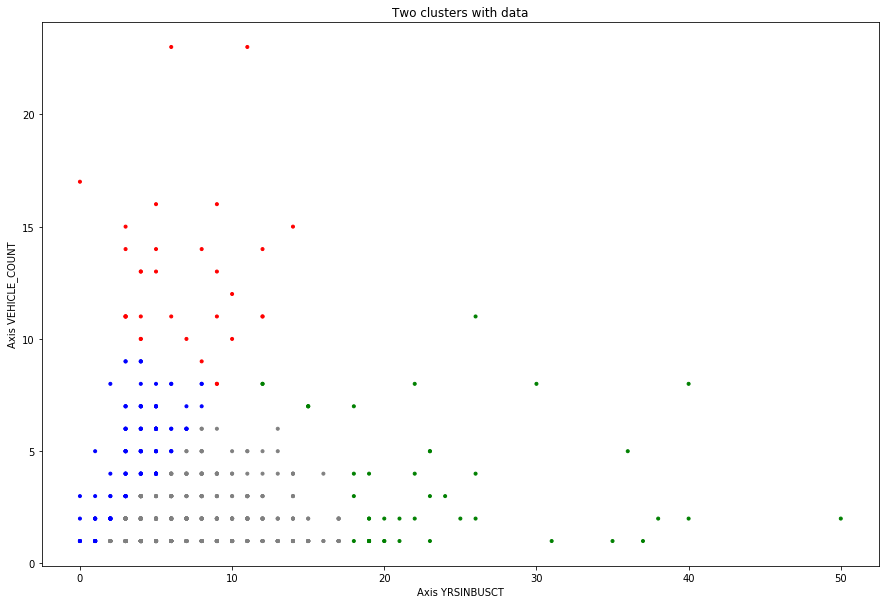

In [282]:
# Generate scatter plot for training data
tmp['CLUSTERS'] = -1
tmp.loc[(tmp['CLUSTER_ID']==-1) & (tmp['CLUSTER_ID_2']==0), 'CLUSTERS'] = 0
tmp.loc[(tmp['CLUSTER_ID']==0) & (tmp['CLUSTER_ID_2']==-1), 'CLUSTERS'] = 1
tmp.loc[(tmp['CLUSTER_ID']==0) & (tmp['CLUSTER_ID_2']==0), 'CLUSTERS'] = 2


colors = list(map(lambda x: 'red' if x == -1 else 'green' if x==0 else 'blue' if x==1 else 'grey' if x==2 else 'pink' if x==3 else 'blue', tmp['CLUSTERS']))
plt.figure(figsize = (15,10))
plt.scatter(tmp['YRSINBUSCT'], tmp['VEHICLE_COUNT'], c=colors, marker=".", picker=True)
plt.title('Two clusters with data')
plt.xlabel('Axis YRSINBUSCT')
plt.ylabel('Axis VEHICLE_COUNT')

plt.show()

In [285]:
import hdbscan

ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
# enlarge this chart below and add descriptions
# Send an HTML 



Text(0.5,1,'Regression of Years in Business over Units Count ')

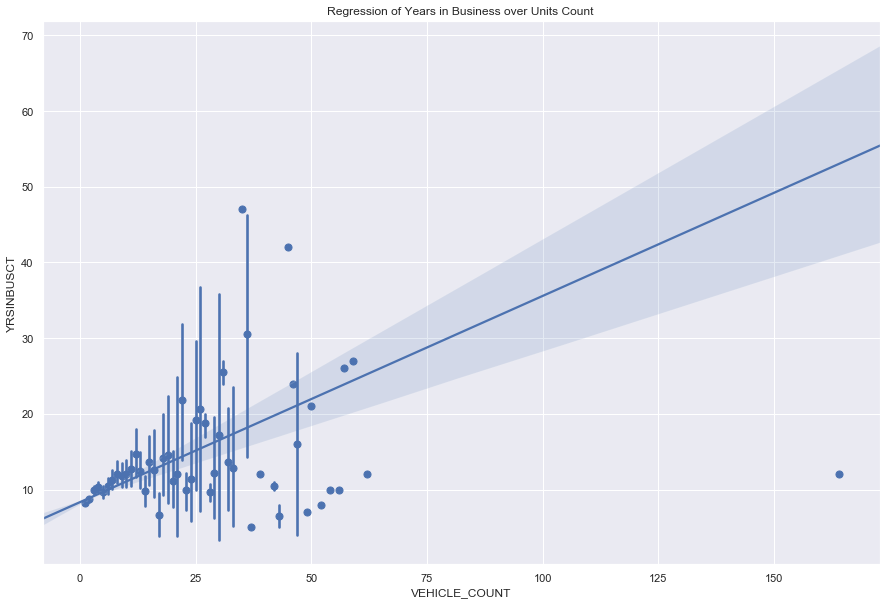

In [203]:
# plt.figure(figsize = (15,10))
sns.set(rc={'figure.figsize':(15,10)})

sns.regplot(x="VEHICLE_COUNT", y="YRSINBUSCT", data=tmp, x_estimator=np.mean)
plt.title('Regression of Years in Business over Units Count ')

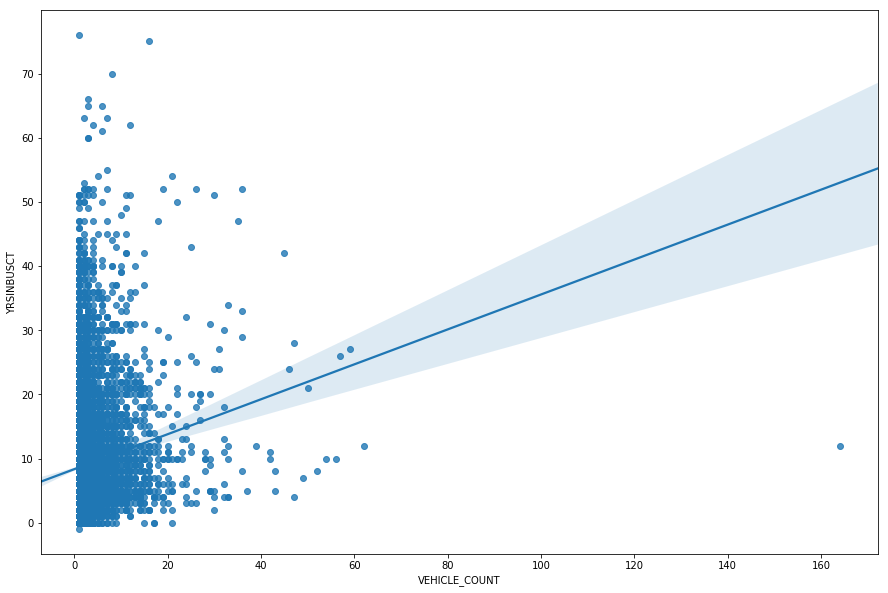

In [196]:
plt.figure(figsize = (15,10))
sns.regplot(x="VEHICLE_COUNT", y="YRSINBUSCT", data=tmp)

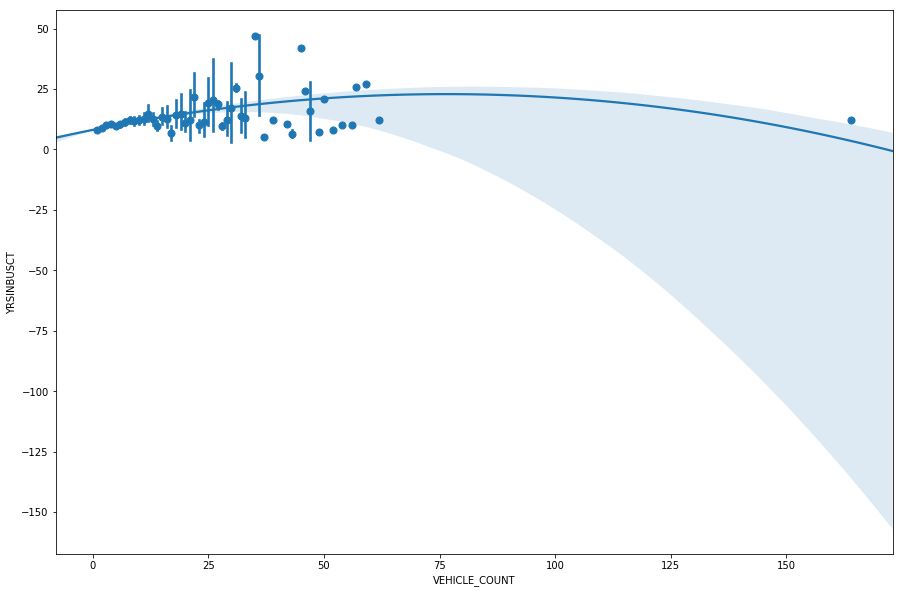

In [197]:
plt.figure(figsize = (15,10))
sns.regplot(x="VEHICLE_COUNT", y="YRSINBUSCT", data=tmp, x_estimator=np.mean, order=2)


In [52]:
from scipy import stats

slope, intercept, r, p, se = stats.linregress(tmp['VEHICLE_COUNT'], tmp['YRSINBUSCT'])
tinv = lambda p, df: abs(stats.t.ppf(p/2, df))

In [57]:
ts = tinv(0.05, len(tmp['VEHICLE_COUNT'])-2)
print(f"slope (95%): {slope:.6f} +/- {ts*se:.6f}")


slope (95%): 0.244845 +/- 0.013775


In [45]:
slope, intercept, r, p, se, r**2

(0.244844705391183,
 8.013117271723114,
 0.13927048601308795,
 2.3829963016547583e-263,
 0.00702794968518658,
 0.019396268274321726)

In [20]:
t = tmp.groupby('CLUSTER_ID').agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'POLICYID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
t['CLAIMS_RATE'] = t['CLAIM_COUNT_PAID']/t['POLICYID']
t['CLAIMS_EXPOSURES'] = t['CLAIM_COUNT_PAID']/t['EARNED_EXPOSURES']
t

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,POLICYID,VEHICLE_COUNT,YRSINBUSCT,CLAIMS_RATE,CLAIMS_EXPOSURES
CLUSTER_ID,,,,,,,
-1,62,419.588148,86,7.488372,3.546512,0.720930,0.147764
0,101,986.619500,636,1.908805,8.276730,0.158805,0.102370
1,18,144.974007,51,4.078431,4.254902,0.352941,0.124160
2,9,76.800000,13,8.000000,6.846154,0.692308,0.117188


In [19]:
t = tmp.groupby('CLUSTER_ID').agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'POLICYID': np.size})
t['CLAIMS_RATE'] = t['CLAIM_COUNT_PAID']/t['POLICYID']
t['CLAIMS_EXPOSURES'] = t['CLAIM_COUNT_PAID']/t['EARNED_EXPOSURES']
t

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,POLICYID,CLAIMS_RATE,CLAIMS_EXPOSURES
CLUSTER_ID,,,,,
-1,3345,39206.233973,10496,0.318693,0.085318
0,79,1239.189052,671,0.117735,0.063751
1,266,5386.298561,1843,0.144330,0.049385
2,79,1825.586346,857,0.092182,0.043274
3,45,822.561349,455,0.098901,0.054707
4,274,3258.410252,1810,0.151381,0.084090
5,42,824.047333,441,0.095238,0.050968
6,160,2569.877652,1231,0.129976,0.062260
7,147,2507.871659,1161,0.126615,0.058615


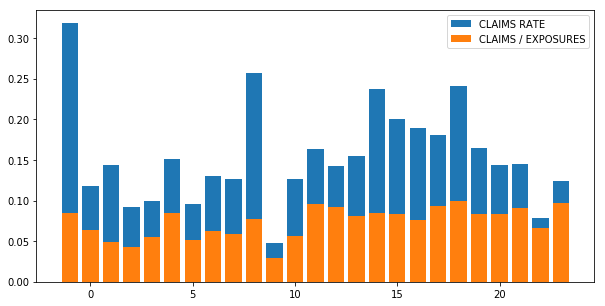

In [30]:
plt.figure(figsize = (10,5))
plt.bar(x = t.index, height = t['CLAIMS_RATE'], label = 'CLAIMS RATE')
plt.bar(x = t.index, height = t['CLAIMS_EXPOSURES'], label = 'CLAIMS / EXPOSURES')
plt.legend()

In [32]:
t.sort_values(by = 'CLAIMS_EXPOSURES')

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,POLICYID,CLAIMS_RATE,CLAIMS_EXPOSURES
CLUSTER_ID,,,,,
9,33,1144.083836,698,0.047278,0.028844
2,79,1825.586346,857,0.092182,0.043274
1,266,5386.298561,1843,0.144330,0.049385
5,42,824.047333,441,0.095238,0.050968
3,45,822.561349,455,0.098901,0.054707
10,163,2886.498441,1291,0.126259,0.056470
7,147,2507.871659,1161,0.126615,0.058615
6,160,2569.877652,1231,0.129976,0.062260
0,79,1239.189052,671,0.117735,0.063751


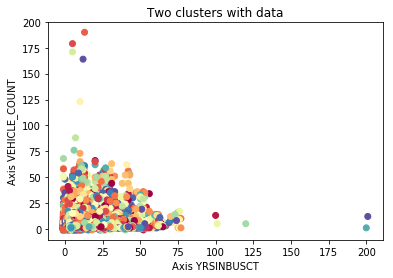

In [21]:
# CLUSTERS VISUALISATION over two FEATURES
# colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', labels))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.scatter(tmp['YRSINBUSCT'], tmp['VEHICLE_COUNT'], c=colors, marker="o", picker=True)
plt.title('Two clusters with data')
plt.xlabel('Axis YRSINBUSCT')
plt.ylabel('Axis VEHICLE_COUNT')
plt.show()

<BarContainer object of 15 artists>

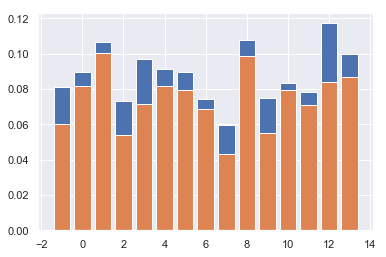

In [146]:
# CLAIMS FREQUENCY OVER CLUSTERS
plt.bar(x = tmp.index, height = tmp['CLAIMS_EXPOSURES'])
plt.bar(x = tmp.index, height = tmp['CLAIMS_RATE'])


In [173]:
tmp = df[df['POLICYSTATUS']=='Renewed'].groupby('CLUSTER_ID').agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'TARGET': np.var, 'POLICYID': np.size})
tmp['CLAIMS_RATE'] = tmp['CLAIM_COUNT_PAID']/tmp['POLICYID']
tmp['CLAIMS_EXPOSURES'] = tmp['CLAIM_COUNT_PAID']/tmp['EARNED_EXPOSURES']
tmp

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,TARGET,POLICYID,CLAIMS_RATE,CLAIMS_EXPOSURES
CLUSTER_ID,,,,,,
-1,5105,77010.474594,0.754716,95780,0.053299,0.066290
0,10,178.654455,0.052983,179,0.055866,0.055974
1,17,185.692806,0.094197,186,0.091398,0.091549
2,7,198.109589,0.034925,254,0.027559,0.035334
3,17,238.205479,0.111451,311,0.054662,0.071367
4,27,359.334247,0.080749,359,0.075209,0.075139
5,13,184.207533,0.065605,185,0.070270,0.070573
6,10,266.259586,0.036127,267,0.037453,0.037557
7,7,135.249315,0.037874,178,0.039326,0.051756


# cluster description

In [58]:
label = 'REGION'
def cluster_label_descr(label, df):
    print('TOTAL DATASET')
    print(df.groupby(label).size())

    print('CLUSTER == 1')
    print(df[df['CLUSTER_ID']==1].groupby(label).size())

    print('CLUSTER == 2')
    print(df[df['CLUSTER_ID']==2].groupby(label).size())

    print('CLUSTER == -1')
    print(df[df['CLUSTER_ID']==2].groupby(label).size())

cluster_label_descr(label, tmp)

TOTAL DATASET
REGION
CALIFORNIA    14438
EAST          10459
FLORIDA        1625
MIDWEST       13367
OTHER            67
SOUTHEAST      7523
TEXAS          5918
WEST           7967
dtype: int64
CLUSTER == 1
REGION
MIDWEST    1843
dtype: int64
CLUSTER == 2
REGION
MIDWEST    857
dtype: int64
CLUSTER == -1
REGION
MIDWEST    857
dtype: int64


In [59]:
# REGION
cluster_label_descr('REGION', tmp)

TOTAL DATASET
REGION
CALIFORNIA    14438
EAST          10459
FLORIDA        1625
MIDWEST       13367
OTHER            67
SOUTHEAST      7523
TEXAS          5918
WEST           7967
dtype: int64
CLUSTER == 1
REGION
MIDWEST    1843
dtype: int64
CLUSTER == 2
REGION
MIDWEST    857
dtype: int64
CLUSTER == -1
REGION
MIDWEST    857
dtype: int64


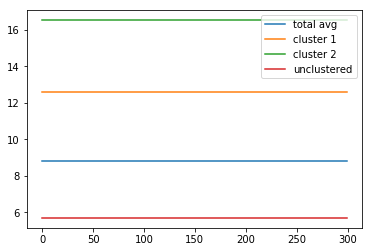

In [64]:
# YEARS IN BUSINESS
def plot_segment(label, df):
    plt.plot([df[label].mean()]*300, label = 'total avg')
    plt.plot([df[df['CLUSTER_ID']==1][label].mean()]*300, label = 'cluster 1')
    plt.plot([df[df['CLUSTER_ID']==2][label].mean()]*300, label = 'cluster 2')
    plt.plot([df[df['CLUSTER_ID']==-1][label].mean()]*300, label = 'unclustered')

    plt.legend()
    
plot_segment('YRSINBUSCT', tmp)

In [61]:
# VEHICLE_COUNT

cluster_label_descr('VEHICLE_COUNT', tmp)

TOTAL DATASET
VEHICLE_COUNT
-1.0        167
 1.0      28383
 2.0      11878
 3.0       6260
 4.0       3953
 5.0       2461
 6.0       1744
 7.0       1276
 8.0       1000
 9.0        679
 10.0       596
 11.0       479
 12.0       370
 13.0       299
 14.0       260
 15.0       197
 16.0       181
 17.0       135
 18.0       108
 19.0       104
 20.0        88
 21.0        64
 22.0        64
 23.0        60
 24.0        54
 25.0        47
 26.0        39
 27.0        40
 28.0        33
 29.0        40
          ...  
 45.0        10
 46.0         5
 47.0         4
 48.0         8
 49.0         5
 50.0         7
 51.0         6
 52.0         6
 53.0         6
 54.0         8
 55.0         1
 56.0         5
 57.0         5
 58.0         3
 59.0         3
 60.0         1
 61.0         3
 62.0         5
 63.0         2
 65.0         2
 66.0         1
 68.0         1
 73.0         1
 76.0         1
 88.0         1
 123.0        1
 164.0        1
 171.0        1
 179.0        1
 190.0      

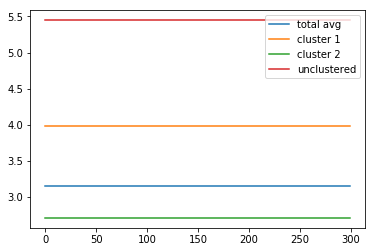

In [65]:
plot_segment('VEHICLE_COUNT', tmp)

In [214]:
#cluster from year to year transition
cl_id = 1
for i in sorted(set(df['POLICY_YEAR'])):
    print(i, df[(df['POLICY_YEAR']==i) & (df['CLUSTER_ID']==cl_id)].size / df[(df['POLICY_YEAR']==i)].size, df[(df['POLICY_YEAR']==i) & (df['CLUSTER_ID']==cl_id)].size)



2015 0.0016764675539048797 2535
2016 0.00180158539514773 2340
2017 0.0022332424710171106 2652
2018 0.0012491733411712836 1326
2019 0.0010965393219000833 975
2020 0.0013800471887103235 1209
2021 0.001577765641119 1014


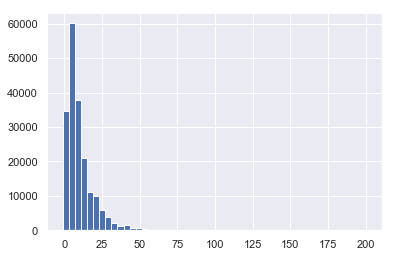

In [219]:
df['YRSINBUSCT'].hist(bins = 50)

In [220]:
df['YRSINBUSCT_GRP'] = pd.qcut(df['YRSINBUSCT'], 10)

tmp = df.groupby(['YRSINBUSCT_GRP']).agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'TARGET': np.var, 'POLICYID': np.size})
tmp['CLAIMS_RATE'] = tmp['CLAIM_COUNT_PAID']/tmp['POLICYID']
tmp['CLAIMS_EXPOSURES'] = tmp['CLAIM_COUNT_PAID']/tmp['EARNED_EXPOSURES']
tmp

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,TARGET,POLICYID,CLAIMS_RATE,CLAIMS_EXPOSURES
YRSINBUSCT_GRP,,,,,,
"(-1.001, 2.0]",1439,14167.421503,1.537934,20081,0.071660,0.101571
"(2.0, 4.0]",2246,22768.477963,0.689813,32201,0.069749,0.098645
"(4.0, 5.0]",1128,13241.065200,0.318554,18288,0.061680,0.085190
"(5.0, 6.0]",830,9794.251832,1.394447,13503,0.061468,0.084744
"(6.0, 8.0]",1180,14342.414032,1.701676,19631,0.060109,0.082273
"(8.0, 10.0]",1237,15943.010212,0.735242,20946,0.059057,0.077589
"(10.0, 12.0]",817,11188.585711,0.409194,14536,0.056205,0.073021
"(12.0, 15.0]",819,10926.075750,1.329327,14125,0.057982,0.074958
"(15.0, 22.0]",1014,15707.254442,0.343372,19786,0.051248,0.064556


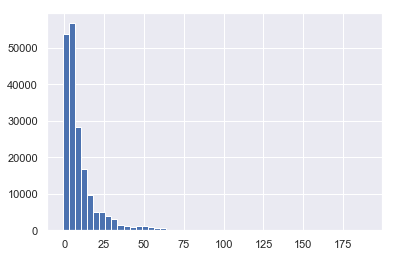

In [221]:
df['VEHICLE_COUNT'].hist(bins = 50)

In [222]:
df['VEHICLE_COUNT_GRP'] = pd.qcut(df['VEHICLE_COUNT'], 10)

tmp = df.groupby(['VEHICLE_COUNT_GRP']).agg({'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum, 'TARGET': np.var, 'POLICYID': np.size})
tmp['CLAIMS_RATE'] = tmp['CLAIM_COUNT_PAID']/tmp['POLICYID']
tmp['CLAIMS_EXPOSURES'] = tmp['CLAIM_COUNT_PAID']/tmp['EARNED_EXPOSURES']
tmp

,CLAIM_COUNT_PAID,EARNED_EXPOSURES,TARGET,POLICYID,CLAIMS_RATE,CLAIMS_EXPOSURES
VEHICLE_COUNT_GRP,,,,,,
"(-1.001, 1.0]",2013,26574.389274,0.112227,29967,0.067174,0.075750
"(1.0, 2.0]",1414,17844.155798,1.240389,23877,0.059220,0.079242
"(2.0, 3.0]",1112,13666.661521,0.432371,18735,0.059354,0.081366
"(3.0, 4.0]",952,11591.177325,0.472296,15650,0.060831,0.082131
"(4.0, 5.0]",729,8689.311601,1.804935,12120,0.060149,0.083896
"(5.0, 7.0]",1176,13617.703166,1.629067,18970,0.061993,0.086358
"(7.0, 10.0]",1254,13962.859555,0.648251,19536,0.064189,0.089810
"(10.0, 14.0]",987,11701.941046,0.784562,16695,0.059119,0.084345
"(14.0, 23.0]",1007,12112.206479,0.267144,17177,0.058625,0.083139


In [ ]:
walk clusters - month to month new - renew - cancel ...
